# ML 1st Evaluation 

## Libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, ChiSqSelector, PCA
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, chi2_contingency, skew, kurtosis
import numpy as np
import pandas as pd
import random

spark = SparkSession.builder \
    .appName("FeatureEngineering") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.memoryOverhead", "1g") \
    .getOrCreate()


24/10/18 23:30:52 WARN Utils: Your hostname, MacBook-Pro-7.local resolves to a loopback address: 127.0.0.1; using 192.168.1.165 instead (on interface en0)
24/10/18 23:30:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/18 23:30:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Reality Data Collection

### Read File

In [2]:
data_path = 'ejemplo.csv'
df = spark.read.csv(data_path, header=True, inferSchema=True)

### Cleaning Data

I added this section because I need a usable database for the next steps. This means the data has to be cleaned to remove mistakes, fix missing values, and make sure everything is consistent. Clean data will help me get reliable results later.

The columns I will use were provided by my teacher, José Luis. This is because the database is very large, with over 40 columns, making it inefficient to analyze every column individually.

In [3]:
# Based on the permutation feature importance provided by my teacher,
# I selected the columns with an importance score of 0.1 or higher.
df = df.select('EDAD', 'PARENT', 'CONACT', 'NIVACAD', 'DHSERSAL1', 'SEXO', 
               'AGEB', 'MUN', 'RELIGION','LOC','ESCOLARI','SITUA_CONYUGAL')

In [21]:
df = df.withColumn('PARENT', F.when(F.col('PARENT').isNull(), 99).otherwise(F.col('PARENT')))
df = df.withColumn('NIVACAD', F.when(F.col('NIVACAD').isNull(), 99).otherwise(F.col('NIVACAD')))
df = df.withColumn('DHSERSAL1', F.when(F.col('DHSERSAL1').isNull(), 99).otherwise(F.col('DHSERSAL1')))
df = df.withColumn('ESCOLARI', F.when(F.col('ESCOLARI').isNull(), 99).otherwise(F.col('ESCOLARI')))
df = df.withColumn('CONACT', F.when(F.col('CONACT').isNull(), 99).otherwise(F.col('CONACT')))
df = df.withColumn('SITUA_CONYUGAL', F.when(F.col('SITUA_CONYUGAL').isNull(), 9).otherwise(F.col('SITUA_CONYUGAL')))


In [22]:
from pyspark.sql import functions as F
null_counts = [F.sum(F.col(col).isNull().cast("int")).alias(col) for col in df.columns]

# Apply the aggregation to count nulls
result = df.agg(*null_counts)

# Show the resulting counts
result.show()

+----+------+------+-------+---------+----+----+---+--------+---+--------+--------------+
|EDAD|PARENT|CONACT|NIVACAD|DHSERSAL1|SEXO|AGEB|MUN|RELIGION|LOC|ESCOLARI|SITUA_CONYUGAL|
+----+------+------+-------+---------+----+----+---+--------+---+--------+--------------+
|   0|     0|     0|      0|        0|   0|   0|  0|       0|  0|       0|             0|
+----+------+------+-------+---------+----+----+---+--------+---+--------+--------------+



In [23]:

# This function will remove outliers from a column in the df.
def outliers(df: DataFrame, column: str) -> DataFrame:

    q1, q3 = df.approxQuantile(column, [0.25, 0.75], 0.05)
    iqr = q3 - q1


    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr


    df_filtered = df.filter(
        (col(column) == -1) | 
        ((col(column) >= lower_bound) & (col(column) <= upper_bound))
    )

    return df_filtered

#In this case I will be using the function for age
df = outliers(df, 'EDAD')

# I will save a copy of the df before indexing AGEB as it is a string column and I need it to be numerical
preindex_df = df
indexer = StringIndexer(inputCol="AGEB", outputCol="AGEB_index")

df = indexer.fit(df).transform(df)
df = df.drop('AGEB')

df.printSchema()

df.show(5)

root
 |-- EDAD: integer (nullable = true)
 |-- PARENT: integer (nullable = true)
 |-- CONACT: integer (nullable = true)
 |-- NIVACAD: integer (nullable = true)
 |-- DHSERSAL1: integer (nullable = true)
 |-- SEXO: integer (nullable = true)
 |-- MUN: integer (nullable = true)
 |-- RELIGION: integer (nullable = true)
 |-- LOC: integer (nullable = true)
 |-- ESCOLARI: integer (nullable = true)
 |-- SITUA_CONYUGAL: integer (nullable = true)
 |-- AGEB_index: double (nullable = false)

+----+------+------+-------+---------+----+---+--------+---+--------+--------------+----------+
|EDAD|PARENT|CONACT|NIVACAD|DHSERSAL1|SEXO|MUN|RELIGION|LOC|ESCOLARI|SITUA_CONYUGAL|AGEB_index|
+----+------+------+-------+---------+----+---+--------+---+--------+--------------+----------+
|  35|     1|    10|     11|        1|   1|108|    1101|  1|       3|             8|      23.0|
|  66|     6|    80|      2|        9|   3|108|    1101|  1|       5|             5|      23.0|
|  78|     6|    80|      2|        

### Exploratory Data Analysis 

#### Univariate Analysis

My code generates histograms and box plots for continuous values, bar charts for categorical values, and summary statistics for all columns. However, some graphs don't look good due to the size of the graph and the amount of data.

Summary statistics:


+-------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+
|summary|              EDAD|            PARENT|            CONACT|           NIVACAD|        DHSERSAL1|              SEXO|              MUN|         RELIGION|               LOC|          ESCOLARI|   SITUA_CONYUGAL|        AGEB_index|
+-------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+
|  count|           1251950|           1251950|           1251950|           1251950|          1251950|           1251950|          1251950|          1251950|           1251950|           1251950|          1251950|           1251950|
|   mean| 31.82144494588442|2.9218906505850875| 42.6176724310076

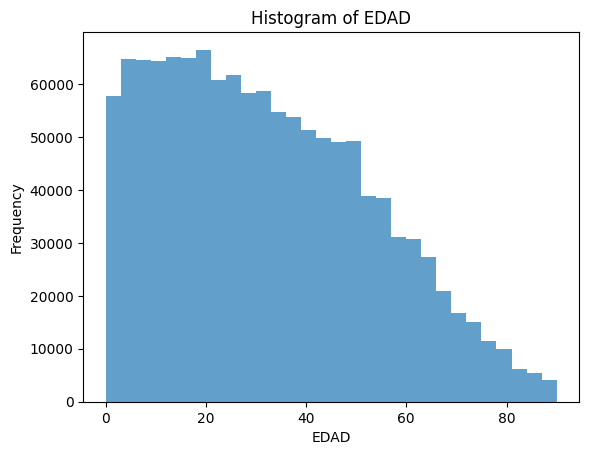

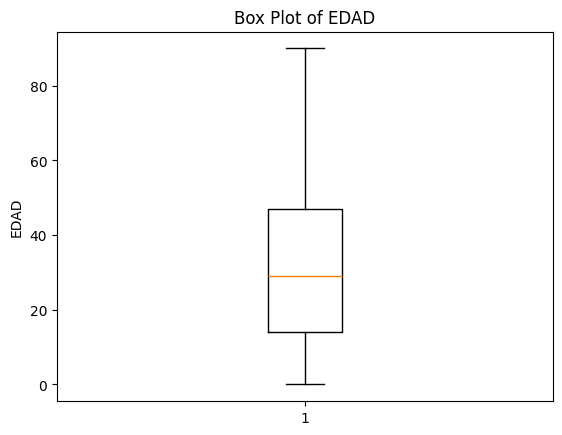

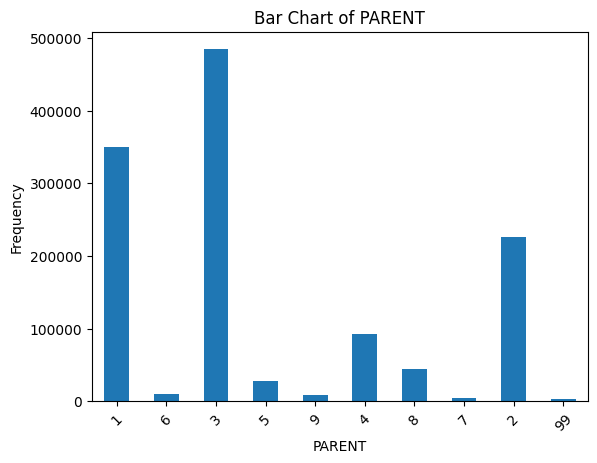

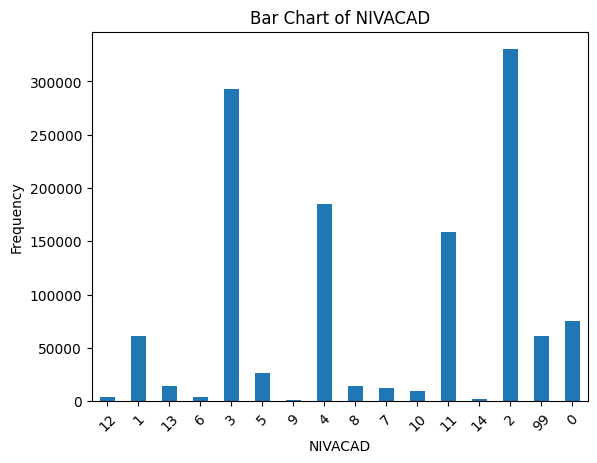

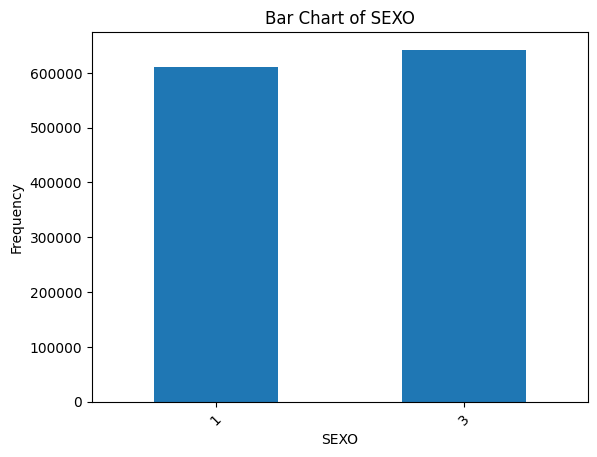

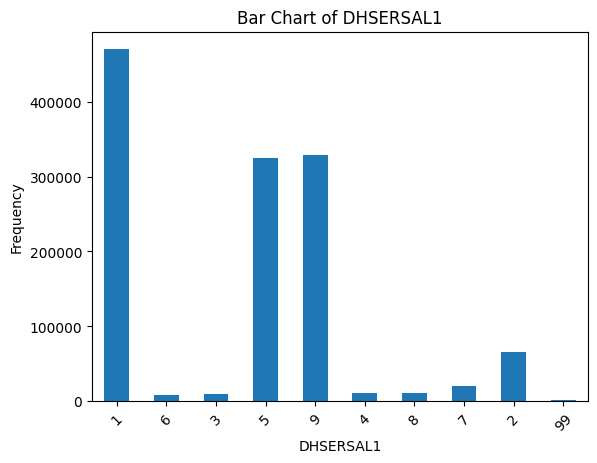

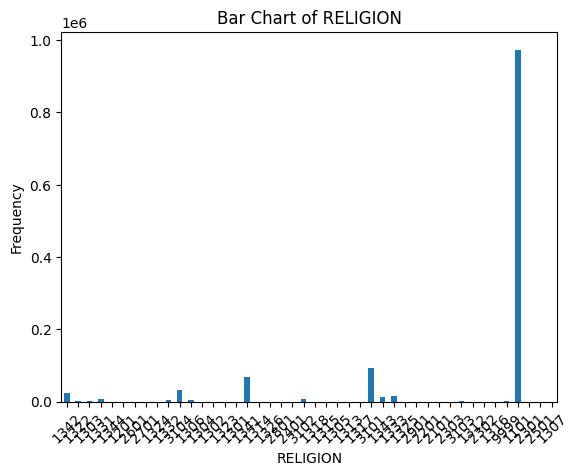

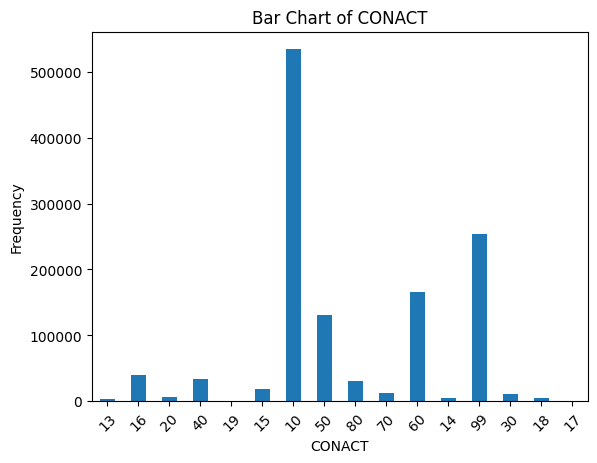

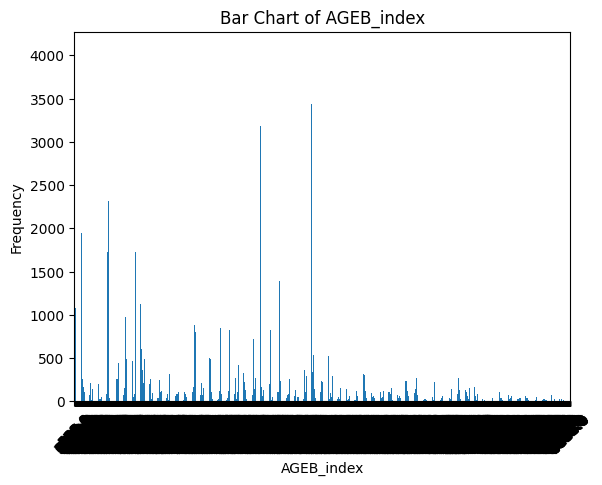

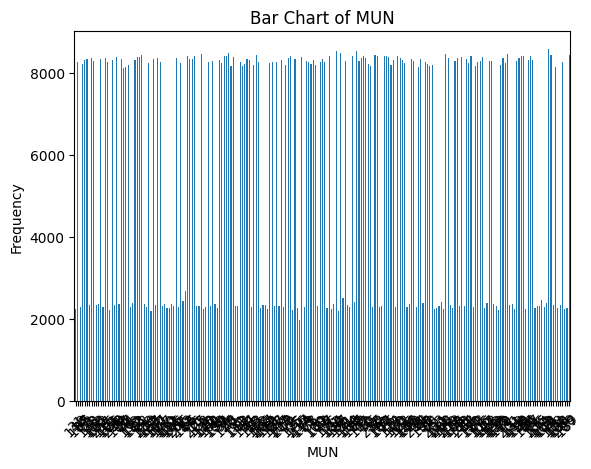

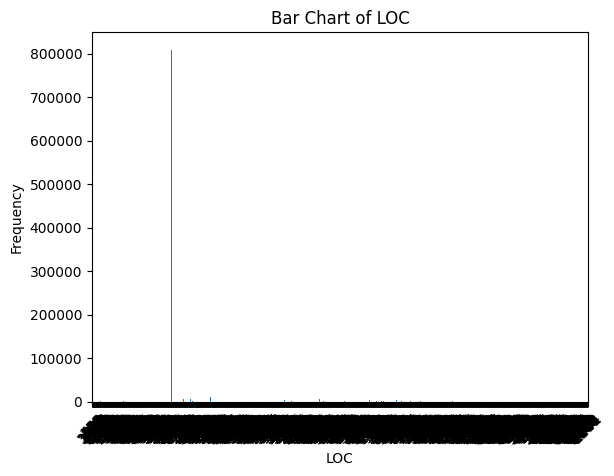

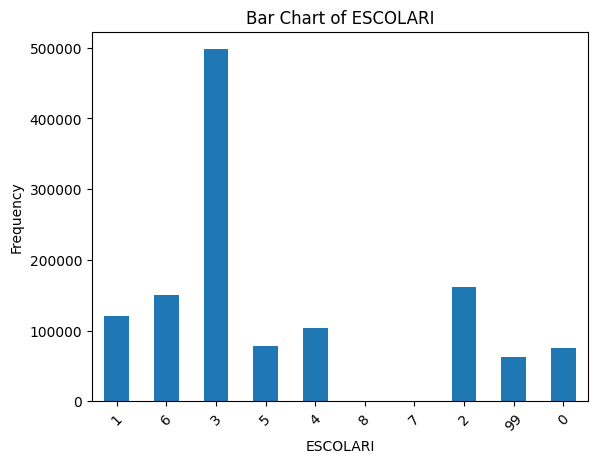

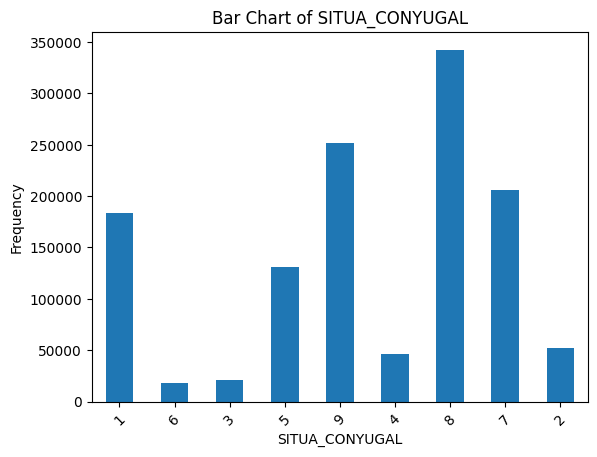

In [24]:
continuous_columns = ['EDAD']
categorical_columns = ['PARENT', 'NIVACAD', 'SEXO', 'DHSERSAL1', 'RELIGION',
                       'CONACT', 'AGEB_index', 'MUN', 'LOC', 'ESCOLARI', 'SITUA_CONYUGAL']

# Function to generate summary statistics for ALL columns
def summary_statistics_for_all(df):
    print("Summary statistics:")
    df.describe().show()

# Plot histogram for a continuous column
def plot_histogram(df, column):
    data = df.select(column).dropna().rdd.map(lambda row: row[0]).collect()
    plt.hist(data, bins=30, alpha=0.7)
    plt.title(f"Histogram of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

# Plot box plot for a continuous column
def plot_boxplot(df, column):
    data = df.select(column).dropna().rdd.map(lambda row: row[0]).collect()
    plt.boxplot(data)
    plt.title(f"Box Plot of {column}")
    plt.ylabel(column)
    plt.show()

# Plot bar chart for a categorical column
def plot_barchart(df, column):
    counts = df.groupBy(column).count().toPandas()
    counts.plot(kind='bar', x=column, y='count', legend=False)
    plt.title(f"Bar Chart of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()

# Generate summary statistics for all columns
summary_statistics_for_all(df)

# Generate histograms and box plots for continuous columns
for column in continuous_columns:
    plot_histogram(df, column)
    plot_boxplot(df, column)

# Generate bar charts for categorical columns
for column in categorical_columns:
    plot_barchart(df, column)


#### Multivariate Analysis

Scatter Plots

The only continuous value in the relevant columns of this dataset is age, which makes it impossible to create a scatter plot since I need two continuous values for that.

Correlation Coefficient

In [25]:
correlation = df.stat.corr('SEXO', 'SITUA_CONYUGAL')
print(f"Correlation between SEXO and SITUA_CONYUGAL: {correlation}")

Correlation between SEXO and SITUA_CONYUGAL: -0.05405307601566594


Cross-tabulation

In [26]:
cross_tab = df.crosstab('NIVACAD', 'RELIGION')
cross_tab.show()

+----------------+------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+----+----+----+----+
|NIVACAD_RELIGION|  1101|1201|1301|1302|1303|1304|1305|1306|1307|1312|1313|1314|1315|1316|1317|1318|1322|1323|1324|1325|1326|1331|1332|1333| 1341|1342|1343|1344|2101|2201|2301|2302|2303|2401|2501|2601|2701|2801|2901| 3101|3102|3103|3104|9999|
+----------------+------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+----+----+----+----+
|               7|  9973|   1|   0|   1|  16|   1|   4|  12|   0|   1|   1|   1|   0|   0|   0|   2|  13|   2|   1|   1|   0|  34|  55| 232|  692| 229|  18|   2|   3|   1|   2|   1|   0|   2|   0|   2|   6|   0|   0|  499|  38|   4| 289|   8|
|              11|124964|  2

Line graphs

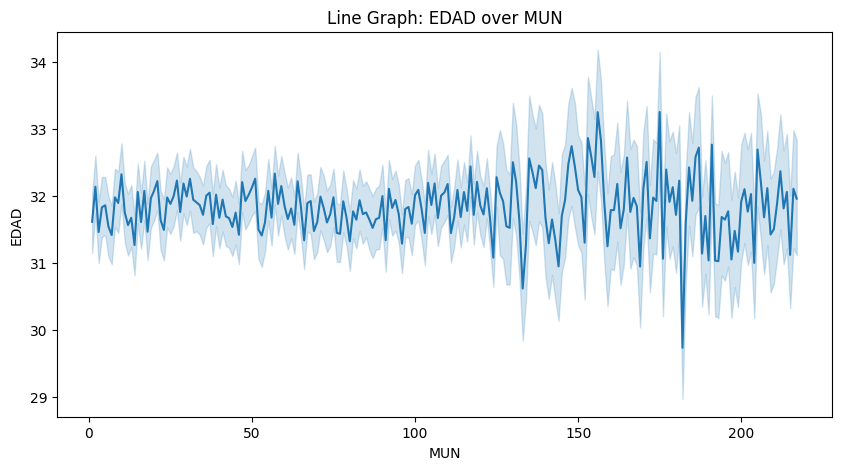

In [27]:
def line_graph(df, x_col, y_col):

    pandas_df = df.select(x_col, y_col).toPandas()

    plt.figure(figsize=(10, 5))
    sns.lineplot(data=pandas_df, x=x_col, y=y_col)
    plt.title(f'Line Graph: {y_col} over {x_col}')
    plt.show()

line_graph(df, 'MUN', 'EDAD')

Covariance

In [28]:
covariance = df.stat.cov('EDAD', 'DHSERSAL1')
print(f"Covariance between 'EDAD' and 'DHSERSAL1': {covariance}")

Covariance between 'EDAD' and 'DHSERSAL1': -5.440628421002784


## Processing Data

### Data Wrangling

Most of the data wrangling has been done in the cleaning data section in Reality Collection

Data Types

In [29]:
df.printSchema()

root
 |-- EDAD: integer (nullable = true)
 |-- PARENT: integer (nullable = true)
 |-- CONACT: integer (nullable = true)
 |-- NIVACAD: integer (nullable = true)
 |-- DHSERSAL1: integer (nullable = true)
 |-- SEXO: integer (nullable = true)
 |-- MUN: integer (nullable = true)
 |-- RELIGION: integer (nullable = true)
 |-- LOC: integer (nullable = true)
 |-- ESCOLARI: integer (nullable = true)
 |-- SITUA_CONYUGAL: integer (nullable = true)
 |-- AGEB_index: double (nullable = false)



Null and Missing Values

In [30]:
from pyspark.sql.functions import col, sum

# Count of null values for each column
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()

+----+------+------+-------+---------+----+---+--------+---+--------+--------------+----------+
|EDAD|PARENT|CONACT|NIVACAD|DHSERSAL1|SEXO|MUN|RELIGION|LOC|ESCOLARI|SITUA_CONYUGAL|AGEB_index|
+----+------+------+-------+---------+----+---+--------+---+--------+--------------+----------+
|   0|     0|     0|      0|        0|   0|  0|       0|  0|       0|             0|         0|
+----+------+------+-------+---------+----+---+--------+---+--------+--------------+----------+



Duplicates, I'll check for columns because there are duplicate rows as more than one people can answer the same.

In [31]:
# Check for duplicate column names
duplicate_columns = [col for col in df.columns if df.columns.count(col) > 1]
print(f"Duplicate columns: {duplicate_columns}")

Duplicate columns: []


Outliers

In [32]:
Q1 = df.approxQuantile("EDAD", [0.25], 0.01)[0]
Q3 = df.approxQuantile("EDAD", [0.75], 0.01)[0]

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

has_outliers = df.filter((col("EDAD") < lower_bound) | (col("EDAD") > upper_bound)).count() > 0
print(f"Are there outliers in 'EDAD'? {'Yes' if has_outliers else 'No'}")


Are there outliers in 'EDAD'? No


In [33]:
threshold = 3

# Check for uncommon categories in all columns
for column in df.columns:
    print(f"Checking column: {column}")
    category_counts = df.groupBy(column).count()
    uncommon_categories = category_counts.filter(col("count") < threshold)

    # Check if there are any uncommon categories
    if uncommon_categories.count() > 0:
        print(f"Uncommon categories found in '{column}':")
        uncommon_categories.show()
    else:
        print(f"No uncommon categories in '{column}'.\n")


Checking column: EDAD
No uncommon categories in 'EDAD'.

Checking column: PARENT
No uncommon categories in 'PARENT'.

Checking column: CONACT
No uncommon categories in 'CONACT'.

Checking column: NIVACAD
No uncommon categories in 'NIVACAD'.

Checking column: DHSERSAL1
No uncommon categories in 'DHSERSAL1'.

Checking column: SEXO
No uncommon categories in 'SEXO'.

Checking column: MUN
No uncommon categories in 'MUN'.

Checking column: RELIGION
No uncommon categories in 'RELIGION'.

Checking column: LOC
Uncommon categories found in 'LOC':
+----+-----+
| LOC|count|
+----+-----+
|3749|    1|
|5695|    2|
|2971|    1|
|4762|    1|
|2606|    1|
|1415|    2|
|3151|    2|
| 988|    1|
|3287|    1|
|3279|    1|
|1085|    1|
|3196|    2|
|3171|    1|
|1290|    1|
|3888|    1|
|1550|    2|
|3132|    2|
|1456|    2|
|2219|    2|
|1723|    2|
+----+-----+
only showing top 20 rows

Checking column: ESCOLARI
No uncommon categories in 'ESCOLARI'.

Checking column: SITUA_CONYUGAL
No uncommon categories

I only had uncommon categories in location variables. I will keep the uncommon categories in location-related columns to maintain data integrity and avoid sampling bias. These locations, though rare, might provide valuable insights or require attention, ensuring my analysis remains comprehensive and accurate without excluding any relevant geographic data.

BIAS

In [34]:
# Check for bias by counting occurrences in the 'ESCOLARI' column
df.groupBy("ESCOLARI").count().show()

+--------+------+
|ESCOLARI| count|
+--------+------+
|       1|119983|
|       6|150524|
|       3|497895|
|       5| 78684|
|       4|104068|
|       8|   533|
|       7|   634|
|       2|161668|
|      99| 62493|
|       0| 75468|
+--------+------+



Most values in ESCOLARI have similar frecuency, with two exceptions.

### Feature Engineering

#### Feature Reduction

Multicollinearity Analysis

In [35]:
from pyspark.ml.stat import Correlation
# Step 1: Assemble all columns into a feature vector
assembler = VectorAssembler(inputCols=df.columns, outputCol="features")
df_vector = assembler.transform(df).select("features")

# Step 2: Compute Pearson correlation matrix
correlation_matrix = Correlation.corr(df_vector, "features", "pearson").head()[0]
print("Pearson Correlation Matrix:\n", correlation_matrix.toArray())

# Optional: Identify highly correlated pairs (above a threshold)
import numpy as np
correlation_array = correlation_matrix.toArray()
threshold = 0.8  # Define the correlation threshold

highly_correlated_pairs = [
    (i, j) for i in range(len(correlation_array)) 
    for j in range(i + 1, len(correlation_array)) 
    if np.abs(correlation_array[i, j]) > threshold
]
print("Highly Correlated Pairs:", highly_correlated_pairs)

24/10/18 23:48:55 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/10/18 23:48:55 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Pearson Correlation Matrix:
 [[ 1.00000000e+00 -1.09521756e-01 -5.04537941e-01 -2.97897315e-01
  -5.99214545e-02  3.01573788e-02  4.37794865e-04 -4.12075647e-02
  -3.33042708e-02 -3.03745765e-01 -4.59782494e-01 -2.58769860e-03]
 [-1.09521756e-01  1.00000000e+00  1.00732225e-01  3.36453236e-02
   6.61648259e-02  1.48802974e-02 -1.14884165e-03  2.44580263e-02
   1.41338185e-02  3.42792773e-02  8.38139909e-02 -1.80762852e-02]
 [-5.04537941e-01  1.00732225e-01  1.00000000e+00  2.92406029e-01
   5.44500532e-02  1.37161412e-01  9.41725366e-04  8.78218522e-04
   2.24051109e-02  3.33162348e-01  4.68184906e-01 -4.03171614e-02]
 [-2.97897315e-01  3.36453236e-02  2.92406029e-01  1.00000000e+00
   5.97596479e-02 -7.71841006e-03  8.50254082e-04  5.18158161e-02
   5.46675954e-04  9.74773729e-01  2.09458897e-01  1.05790136e-02]
 [-5.99214545e-02  6.61648259e-02  5.44500532e-02  5.97596479e-02
   1.00000000e+00 -1.44343500e-02 -9.34081756e-04  1.85005829e-01
   1.93993990e-02  7.58218235e-02 -4.400817

Analysis and Plot 'Feature Importance' features

In [36]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import when

# Step 1: Filter out invalid labels (if any)
df_cleaned = df.filter((df['SITUA_CONYUGAL'] >= 0) & (df['SITUA_CONYUGAL'] < 100))

# Step 2: Index the "MUN" column
indexer = StringIndexer(inputCol="MUN", outputCol="MUN_index").fit(df_cleaned)
df_cleaned = indexer.transform(df_cleaned)

# Step 3: OneHotEncode the indexed "MUN_index" column
encoder = OneHotEncoder(inputCol="MUN_index", outputCol="MUN_enc")
df_cleaned = encoder.fit(df_cleaned).transform(df_cleaned)

# Step 4: Assemble features into a single feature vector
assembler = VectorAssembler(
    inputCols=["EDAD", "DHSERSAL1", "MUN_enc"], 
    outputCol="features"
)
df_vector = assembler.transform(df_cleaned)

# Step 5: Train the Decision Tree model
dt = DecisionTreeClassifier(labelCol="SITUA_CONYUGAL", featuresCol="features", maxDepth=5)
model = dt.fit(df_vector)

# Optional: Display schema to verify everything is correct
df_vector.printSchema()



root
 |-- EDAD: integer (nullable = true)
 |-- PARENT: integer (nullable = true)
 |-- CONACT: integer (nullable = true)
 |-- NIVACAD: integer (nullable = true)
 |-- DHSERSAL1: integer (nullable = true)
 |-- SEXO: integer (nullable = true)
 |-- MUN: integer (nullable = true)
 |-- RELIGION: integer (nullable = true)
 |-- LOC: integer (nullable = true)
 |-- ESCOLARI: integer (nullable = true)
 |-- SITUA_CONYUGAL: integer (nullable = true)
 |-- AGEB_index: double (nullable = false)
 |-- MUN_index: double (nullable = false)
 |-- MUN_enc: vector (nullable = true)
 |-- features: vector (nullable = true)



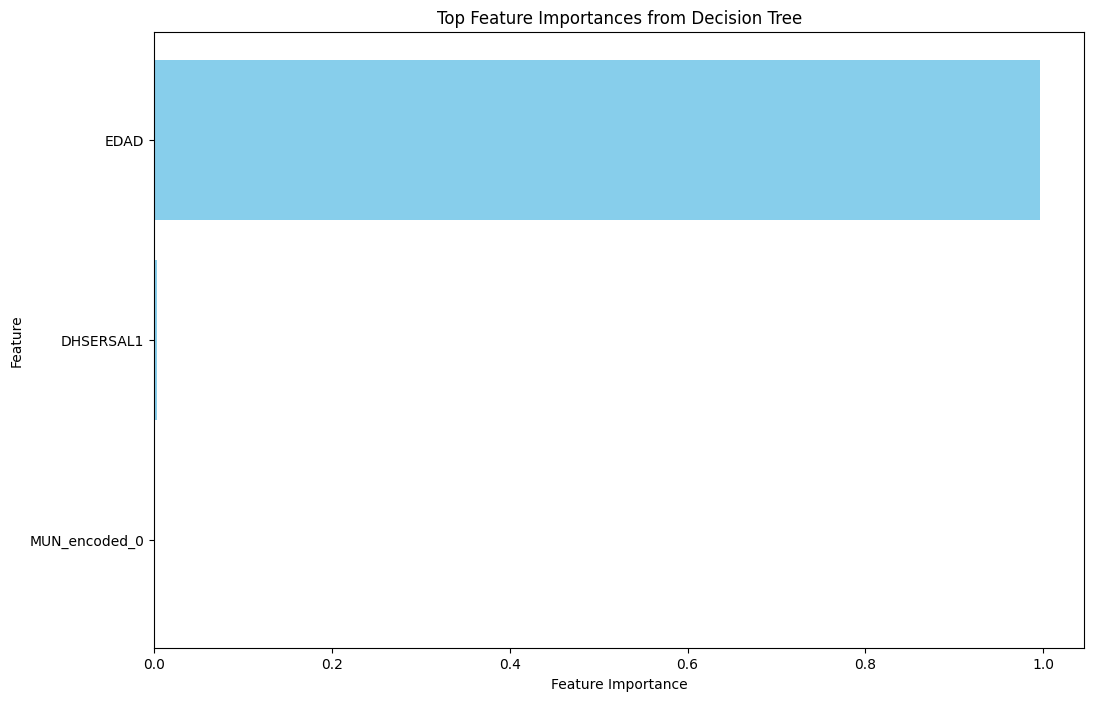

In [37]:
# Step 1: Extract feature importances as an array
importances = model.featureImportances.toArray()

# Step 2: Create a list of feature names used in the VectorAssembler
feature_names = ["EDAD", "DHSERSAL1"] + [f"MUN_encoded_{i}" for i in range(len(importances) - 2)]

# Step 3: Create a DataFrame with feature names and their importances
import pandas as pd

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Step 4: Filter out features with 0 importance
importance_df = importance_df[importance_df['Importance'] > 0]

# Step 5: Sort by importance and select the top N features (e.g., top 20)
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

# Step 6: Plot the top N feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))  # Adjust figure size for better visibility
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top Feature Importances from Decision Tree')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

#### Encoding Categorical Values

In [38]:
df.printSchema()

root
 |-- EDAD: integer (nullable = true)
 |-- PARENT: integer (nullable = true)
 |-- CONACT: integer (nullable = true)
 |-- NIVACAD: integer (nullable = true)
 |-- DHSERSAL1: integer (nullable = true)
 |-- SEXO: integer (nullable = true)
 |-- MUN: integer (nullable = true)
 |-- RELIGION: integer (nullable = true)
 |-- LOC: integer (nullable = true)
 |-- ESCOLARI: integer (nullable = true)
 |-- SITUA_CONYUGAL: integer (nullable = true)
 |-- AGEB_index: double (nullable = false)



In [39]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql import SparkSession

# Step 1: Identify categorical columns to encode
categorical_cols = ["SEXO", "RELIGION", "LOC", "SITUA_CONYUGAL"]

# Step 2: Apply StringIndexer to convert categorical columns to numerical indices
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_index").fit(df)
    for col in categorical_cols
]

for indexer in indexers:
    df = indexer.transform(df)

# Step 3: Use OneHotEncoder with the correct new API
encoder = OneHotEncoder(
    inputCols=[f"{col}_index" for col in categorical_cols],
    outputCols=[f"{col}_encoded" for col in categorical_cols]
)

df_encoded = encoder.fit(df).transform(df)

# Step 4: Verify encoded columns
df_encoded.select(*[f"{col}_encoded" for col in categorical_cols]).show(truncate=False)





+-------------+----------------+----------------+----------------------+
|SEXO_encoded |RELIGION_encoded|LOC_encoded     |SITUA_CONYUGAL_encoded|
+-------------+----------------+----------------+----------------------+
|(1,[],[])    |(43,[0],[1.0])  |(1767,[0],[1.0])|(8,[0],[1.0])         |
|(1,[0],[1.0])|(43,[0],[1.0])  |(1767,[0],[1.0])|(8,[4],[1.0])         |
|(1,[],[])    |(43,[0],[1.0])  |(1767,[0],[1.0])|(8,[4],[1.0])         |
|(1,[0],[1.0])|(43,[0],[1.0])  |(1767,[0],[1.0])|(8,[1],[1.0])         |
|(1,[0],[1.0])|(43,[0],[1.0])  |(1767,[0],[1.0])|(8,[3],[1.0])         |
|(1,[],[])    |(43,[0],[1.0])  |(1767,[0],[1.0])|(8,[3],[1.0])         |
|(1,[],[])    |(43,[1],[1.0])  |(1767,[0],[1.0])|(8,[0],[1.0])         |
|(1,[0],[1.0])|(43,[0],[1.0])  |(1767,[0],[1.0])|(8,[4],[1.0])         |
|(1,[0],[1.0])|(43,[0],[1.0])  |(1767,[0],[1.0])|(8,[5],[1.0])         |
|(1,[],[])    |(43,[0],[1.0])  |(1767,[0],[1.0])|(8,[0],[1.0])         |
|(1,[0],[1.0])|(43,[0],[1.0])  |(1767,[0],[1.0])|(8

#### Create New Features

In [40]:
df = df.withColumn(
    "Age_Group",
    when(col("EDAD") < 18, "Child")
    .when((col("EDAD") >= 18) & (col("EDAD") < 35), "Young Adult")
    .when((col("EDAD") >= 35) & (col("EDAD") < 60), "Adult")
    .otherwise("Senior")
)

In [41]:
df.show(2)

+----+------+------+-------+---------+----+---+--------+---+--------+--------------+----------+----------+--------------+---------+--------------------+---------+
|EDAD|PARENT|CONACT|NIVACAD|DHSERSAL1|SEXO|MUN|RELIGION|LOC|ESCOLARI|SITUA_CONYUGAL|AGEB_index|SEXO_index|RELIGION_index|LOC_index|SITUA_CONYUGAL_index|Age_Group|
+----+------+------+-------+---------+----+---+--------+---+--------+--------------+----------+----------+--------------+---------+--------------------+---------+
|  35|     1|    10|     11|        1|   1|108|    1101|  1|       3|             8|      23.0|       1.0|           0.0|      0.0|                 0.0|    Adult|
|  66|     6|    80|      2|        9|   3|108|    1101|  1|       5|             5|      23.0|       0.0|           0.0|      0.0|                 4.0|   Senior|
+----+------+------+-------+---------+----+---+--------+---+--------+--------------+----------+----------+--------------+---------+--------------------+---------+
only showing top 2 row

## Linear Regression

### Create a Dataset

Use subset data from ingei

In [42]:
df.show(2)

+----+------+------+-------+---------+----+---+--------+---+--------+--------------+----------+----------+--------------+---------+--------------------+---------+
|EDAD|PARENT|CONACT|NIVACAD|DHSERSAL1|SEXO|MUN|RELIGION|LOC|ESCOLARI|SITUA_CONYUGAL|AGEB_index|SEXO_index|RELIGION_index|LOC_index|SITUA_CONYUGAL_index|Age_Group|
+----+------+------+-------+---------+----+---+--------+---+--------+--------------+----------+----------+--------------+---------+--------------------+---------+
|  35|     1|    10|     11|        1|   1|108|    1101|  1|       3|             8|      23.0|       1.0|           0.0|      0.0|                 0.0|    Adult|
|  66|     6|    80|      2|        9|   3|108|    1101|  1|       5|             5|      23.0|       0.0|           0.0|      0.0|                 4.0|   Senior|
+----+------+------+-------+---------+----+---+--------+---+--------+--------------+----------+----------+--------------+---------+--------------------+---------+
only showing top 2 row

Assign x and y

In [43]:
input_cols = ['EDAD', 'PARENT', 'CONACT', 'NIVACAD', 'DHSERSAL1', 'SEXO', #x
               'AGEB_index', 'MUN', 'RELIGION','LOC','ESCOLARI']
output_col = 'SITUA_CONYUGAL'#y

Create train and test data

In [44]:
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
assembled_df = assembler.transform(df).select("features", col(output_col).alias("label"))
train_data, test_data = assembled_df.randomSplit([0.75, 0.25], seed=42)

### Select the Classifier

In [45]:
lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_data)

# Step 5: Make predictions on the test data
predictions = lr_model.transform(test_data)


24/10/18 23:50:22 WARN Instrumentation: [ba981ce8] regParam is zero, which might cause numerical instability and overfitting.
24/10/18 23:50:23 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [46]:
# Show predictions
predictions.select("features", "label", "prediction").show()

+--------------------+-----+-----------------+
|            features|label|       prediction|
+--------------------+-----+-----------------+
|[0.0,3.0,99.0,99....|    9|9.573935321256812|
|[0.0,3.0,99.0,99....|    9|9.533493660024194|
|[0.0,3.0,99.0,99....|    9|9.574644682053613|
|[0.0,3.0,99.0,99....|    9|9.578864396133826|
|[0.0,3.0,99.0,99....|    9|9.543418184407376|
|[0.0,3.0,99.0,99....|    9|9.580081092789644|
|[0.0,3.0,99.0,99....|    9|9.277507393128921|
|[0.0,3.0,99.0,99....|    9|9.154967801637062|
|[0.0,3.0,99.0,99....|    9| 9.57911955947299|
|[0.0,3.0,99.0,99....|    9|9.486791767687379|
|[0.0,3.0,99.0,99....|    9|9.316904406829444|
|[0.0,3.0,99.0,99....|    9|9.579901048265938|
|[0.0,3.0,99.0,99....|    9| 9.27602337459185|
|[0.0,3.0,99.0,99....|    9|9.340055258540641|
|[0.0,3.0,99.0,99....|    9|9.582251097987745|
|[0.0,3.0,99.0,99....|    9|9.585392083441294|
|[0.0,3.0,99.0,99....|    9|9.225535482638204|
|[0.0,3.0,99.0,99....|    9|9.569338495418284|
|[0.0,3.0,99.

### Train the Model

In [47]:
training_summary = lr_model.summary
print(f"R2: {training_summary.r2}")
print(f"RMSE: {training_summary.rootMeanSquaredError}")
mae = predictions.withColumn("abs_error", abs(col("label") - col("prediction"))) \
    .agg(avg("abs_error").alias("MAE")).collect()[0]["MAE"]

print(f"Mean Absolute Error (MAE): {mae}")

R2: 0.3027689087047598
RMSE: 2.326396083483114


Mean Absolute Error (MAE): 1.7999576092013236


### Prediction

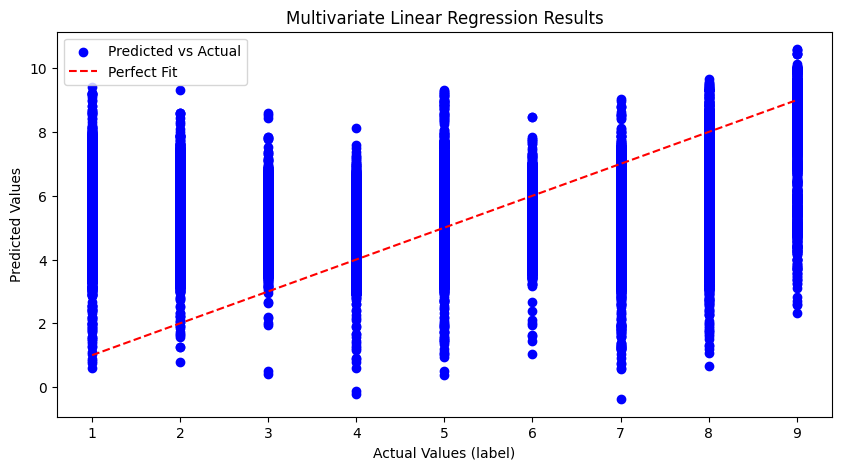

In [48]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf, col
import matplotlib.pyplot as plt

# Step 1: Define a UDF to convert vector to an array
def vector_to_array(v):
    """Convert Dense or Sparse Vector to a Python list."""
    return v.toArray().tolist()

vector_to_array_udf = udf(vector_to_array)

# Step 2: Use the UDF to extract feature values into a column of arrays
predictions_with_features = predictions.withColumn(
    "features_array", vector_to_array_udf(col("features"))
)

# Step 3: Convert the predictions DataFrame to Pandas for plotting
result_pd = predictions_with_features.select("label", "prediction").toPandas()

# Step 4: Plot Actual vs Predicted Values
plt.figure(figsize=(10, 5))
plt.scatter(result_pd["label"], result_pd["prediction"], color='blue', label='Predicted vs Actual')

# Add a perfect fit line for comparison
plt.plot([result_pd["label"].min(), result_pd["label"].max()],
         [result_pd["label"].min(), result_pd["label"].max()],
         color='red', linestyle='--', label='Perfect Fit')

# Plot settings
plt.xlabel("Actual Values (label)")
plt.ylabel("Predicted Values")
plt.title("Multivariate Linear Regression Results")
plt.legend()

# Show the plot
plt.show()



## Logistic Regression

### Create a Dataset

In [49]:
# Filter out rows where the label ('SITUA_CONYUGAL') is -1
clean_df = df.filter(col("SITUA_CONYUGAL") != -1)

# Define input (X) and output (y) columns
input_cols = ['EDAD', 'PARENT', 'CONACT', 'NIVACAD', 'DHSERSAL1', 'SEXO', 
              'AGEB_index', 'MUN', 'RELIGION', 'LOC', 'ESCOLARI']
output_col = 'SITUA_CONYUGAL'  # Target column for marital status

# Assemble input features into a vector
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
data_with_features = assembler.transform(clean_df).select("features", col(output_col).alias("label"))

# Split the data into training and test sets (75% training, 25% testing)
train_data, test_data = data_with_features.randomSplit([0.75, 0.25], seed=42)



### Select the Classifier

In [50]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, abs, avg, pow

# Initialize the multinomial logistic regression model
mlr = LogisticRegression(
    featuresCol="features", 
    labelCol="label", 
    predictionCol="prediction",
    maxIter=10, 
    regParam=0.3, 
    elasticNetParam=0.8, 
    family="multinomial"
)

# Fit the model on the training data
mlr_model = mlr.fit(train_data)

# Make predictions on the test data
predictions = mlr_model.transform(test_data)

# Display predictions
predictions.select("features", "label", "prediction", "probability").show(truncate=False)

# Step 1: Calculate Accuracy (R² equivalent for classification)
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy (R² equivalent for classification): {accuracy}")

# Step 2: Calculate MSE (Mean Squared Error)
mse = predictions.withColumn("squared_error", pow(col("label") - col("prediction"), 2)) \
    .agg(avg("squared_error").alias("MSE")).collect()[0]["MSE"]
print(f"Mean Squared Error (MSE): {mse}")

# Step 3: Calculate MAE (Mean Absolute Error)
mae = predictions.withColumn("absolute_error", abs(col("label") - col("prediction"))) \
    .agg(avg("absolute_error").alias("MAE")).collect()[0]["MAE"]
print(f"Mean Absolute Error (MAE): {mae}")



+----------------------------------------------------------+-----+----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                  |label|prediction|probability                                                                                                                                                                                              |
+----------------------------------------------------------+-----+----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.0,3.0,99.0,99.0,1.0,1.0,4.0,105.0,1101.0,20.0,99.0]    |9    |9.0       |[9.233209437138451E-7,0.127812385392426,0.03587043795826829,0.014318929495089092,0.

Accuracy (R² equivalent for classification): 0.46259232366140685


Mean Squared Error (MSE): 11.046743201875742


Mean Absolute Error (MAE): 2.0482306164293735


### Prediction

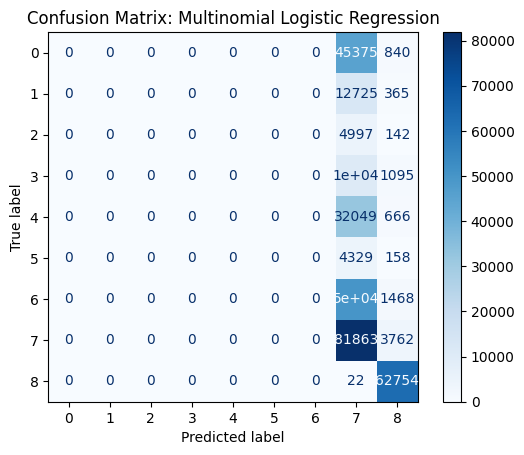

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Extract predicted and actual labels
predictions_and_labels = predictions.select("label", "prediction").toPandas()

# Create the confusion matrix
cm = confusion_matrix(predictions_and_labels["label"], predictions_and_labels["prediction"])

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

# Add plot title and display the plot
plt.title("Confusion Matrix: Multinomial Logistic Regression")
plt.show()
